# TITANIC 

This is the analysis and models I developed for a  kaggle competition hosted at https://www.kaggle.com/c/titanic/data. This competition has as the main objective to predict which passengers survived titanic sink by their data. 
Kaggle disposes two datasets one for model training, with labels for died and survived, and one for evaluation at the platform, without any label. 
The given data for solve this problem are: 

In [ ]:
from IPython.display import Image
Image(filename='cap.png')

## Exploratory Analysis

In [1]:
#Let's import everything we need, and set max columns and rows for none 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
import scipy.stats as stats
import numpy as np
import re
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression 
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression 
from sklearn.feature_selection import RFECV
from mlxtend.feature_selection import ExhaustiveFeatureSelector as EFS  
from sklearn.model_selection import LeaveOneOut
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

/home/pedro/snap/jupyter/common/lib/python3.7/site-packages/joblib/_multiprocessing_helpers.py:45: UserWarning: [Errno 13] Permission denied.  joblib will operate in serial mode
  warnings.warn('%s.  joblib will operate in serial mode' % (e,))


In [2]:
#read our files nd take a look 
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
print('Train shape:',train.shape,'\n','Test shape',test.shape)
train.head()

Train shape: (891, 12) 
 Test shape (418, 11)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
train.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [4]:
train.Age = train.Age.fillna(train.Age.mean())

As we can see our variables can be splited at these groups:  
**Independent variables**
* **Categorical** : Pclass(which class the passenger was), Embarked(where he/she boarded), Sex 
* **Quatitative** : Age, Fare(how much was the ticket), SibSp (number of siblings per suppose aboard), Parch  (number of children per parents aboard) 
* **'Tricky ones'**: Name, Ticket, Cabin (which cabin the passenger was)
* **Key**: PassengerId <br>

**Dependent variables**
* **Categorical** : Survived (0 = No, 1 = Yes) <br>

We can see here that our variables **Name**, **Ticket** and **Cabin** require some kind of feature engineering and our attention. But the rest seam to be OK.




### Tricky Variables : Name, Ticket number, Cabin


#### Tricky 1: Name
Starting with **Name**, we can actually get the title from the person's name. For example: Braund, Mr. Owen Harris has a Mr. title. Then we can classify people by theirs titles and see if there's any relationship between them and the survivor rate 

In [5]:
titles = train['Name'].str.extract(pat = '([,].{1,13}[.])') #select titles 
titles.rename(columns = {0:'Name'},inplace=True) # rename titles df 
titles = titles.Name.str.slice(start=2, stop=-1) # takes only the title 
titles.value_counts()

Mr              517
Miss            182
Mrs             125
Master           40
Dr                7
Rev               6
Mlle              2
Col               2
Major             2
Jonkheer          1
Ms                1
Lady              1
Don               1
the Countess      1
Sir               1
Capt              1
Mme               1
Name: Name, dtype: int64

We can see that there are a lot of diferent titles and only some of them seam to have a statistical significance, let's group them into only four groups: **Mr, Mrs, Miss & Master**. Most of the other titles seams to be a outliers and won't help us at our task. 

In [6]:
def replace_titles(x):
    title=x['Title']
    if title in ['Dr','Don', 'Major', 'Capt', 'Jonkheer', 'Rev', 'Col', 'Sir']: 
        return 'Mr' #These all titles can be grouped at title !
    elif title in ['the Countess','Lady','Mme']: 
        return 'Mrs'# They are actually outliers
    elif title in ['Mlle', 'Ms']:
        return 'Miss' 
    else:
        return title
    
train['Title']= titles
train.Title = train.apply(replace_titles, axis=1)
train.groupby(by = 'Title').mean()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
Title,,,,,,,
Master,414.975000,0.575000,2.625000,7.086662,2.300000,1.375000,34.703125
Miss,411.967568,0.702703,2.291892,23.373882,0.702703,0.540541,43.800092
Mr,457.697026,0.161710,2.369888,32.281402,0.289963,0.150558,24.842176
Mrs,455.718750,0.796875,1.976562,35.053789,0.687500,0.812500,45.607161


In [7]:
train.Title.value_counts()

Mr        538
Miss      185
Mrs       128
Master     40
Name: Title, dtype: int64

Take a look at survived mean by class title. You'll see that **Mr** are the class with lowest surviving rate. Then we see that Master have a 3.5x more chance to survive than man, and far less age. So we can infer Master was a title for young boys. <br>
We can also see that the woman's chance to survive were much higher than the othes and the maried ones even better chance. It's very clear the **"woman and children first!"**, since their surviving rate were far higher than man. 

### Tricky n 2 : Cabin

Cabin specifies where the passenger was staying. A lot of them were NaN values and it's hard to use any possible subgroups like floor since there are not enough of events inside of them. So I managed Cabin using the fact of the passenger has one or not (with for have cabin, and without for dose't have cabin)

In [8]:
train['Floor'] = train.Cabin.str.slice(start=0, stop=1)
train.loc[~train.Cabin.isnull(),'Cabin'] = 'With'
train.Cabin.fillna('Without', inplace=True)
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,Floor
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,Without,S,Mr,NaN
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,With,C,Mrs,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,Without,S,Miss,NaN
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,With,S,Mrs,C
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,Without,S,Mr,NaN


In [9]:
train.groupby(by = 'Cabin').mean()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
Cabin,,,,,,,
With,455.401961,0.666667,1.196078,35.258349,0.441176,0.436275,76.141504
Without,443.208151,0.299854,2.639010,28.048341,0.547307,0.365357,19.157325


Passengers with cabin had better surviving chances than those who didn't have

In [10]:
# Codify the categorical var using dummies 
qualitative = ['Embarked', 'Title', 'Sex','Cabin', 'Pclass']
train = pd.get_dummies(train, columns=qualitative).drop(columns= ['Ticket','Name', 'Floor']).set_index('PassengerId')

# Turn our data standard using sklearn scaler
independent = np.ravel(train.columns[train.columns!= 'Survived'])
scaler = StandardScaler()

X_std = scaler.fit_transform(train[independent]) # X standardized  

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X_std, train.Survived, test_size = 0.2, random_state = 42) 

print('X_train:',len(X_train),type(X_train),'    X_test:',len(X_test),type(X_test),'\n','y_train: ',len(y_train),type(y_train),'    y_test: ',len(y_test), type(y_test))

X_train: 712 <class 'numpy.ndarray'>     X_test: 179 <class 'numpy.ndarray'> 
 y_train:  712 <class 'pandas.core.series.Series'>     y_test:  179 <class 'pandas.core.series.Series'>


## What is the best feature subset? How can we optmize it? 

In [12]:
logreg = LogisticRegression()

logreg.fit(X_train, y_train) ## here comes the training 

selector = RFECV(logreg, step=1, cv=5)
selector = selector.fit(X_train, y_train)
print('\~', np.ravel(np.ix_(~selector.support_)).tolist())
print(independent)

\~ [4, 5, 8]
['Age' 'SibSp' 'Parch' 'Fare' 'Embarked_C' 'Embarked_Q' 'Embarked_S'
 'Title_Master' 'Title_Miss' 'Title_Mr' 'Title_Mrs' 'Sex_female'
 'Sex_male' 'Cabin_With' 'Cabin_Without' 'Pclass_1' 'Pclass_2' 'Pclass_3']


In [13]:
best_features = ['Age', 'SibSp', 'Parch', 'Fare','Embarked_S', 'Title_Mr', 'Title_Mrs', 'Title_Master', 'Cabin_With', 
       'Cabin_Without', 'Sex_female', 'Sex_male', 'Pclass_2', 'Pclass_3']

X_train = pd.DataFrame(X_train, columns= independent)
X_test = pd.DataFrame(X_test, columns= independent)

X_train = np.array(X_train[best_features])
X_test = np.array(X_test[best_features])

logreg.fit(X_train, y_train)
logreg.score(X_test, y_test)

0.8100558659217877

#### On Kaggle: 0.78229

In [14]:
y_pred = logreg.predict(X_test)

confusion_matrix = confusion_matrix(y_test, y_pred, labels = [1,0])
print(confusion_matrix)

[[56 18]
 [16 89]]


In [15]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.83      0.85      0.84       105
           1       0.78      0.76      0.77        74

    accuracy                           0.81       179
   macro avg       0.80      0.80      0.80       179
weighted avg       0.81      0.81      0.81       179



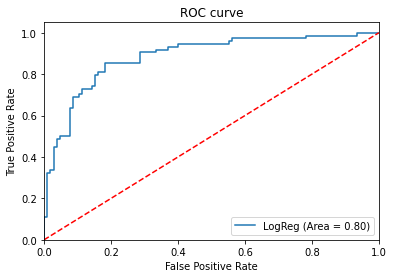

In [16]:
logit_roc_auc = roc_auc_score(y_test, logreg.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='LogReg (Area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

## KNN

In [17]:
from sklearn import neighbors

knn = neighbors.KNeighborsClassifier(n_neighbors = 3)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
acc_knn = knn.score(X_test, y_test) * 100 # test
print(acc_knn)
#curva custo x temp , mesma com test 

82.12290502793296


In [22]:
X_std = pd.DataFrame(X_std, columns= [independent])
knn.fit( X_std[best_features], train['Survived'])
y_pred = to_kaggle(knn)
y_pred[['PassengerId','Survived']].to_csv(path_or_buf= r'/home/pedro/titanic/titanic_project/knn', index=False)

#### 0.727 on test at Kaggle 

## Random Forrest 

In [23]:
from sklearn.ensemble import RandomForestClassifier
RF = RandomForestClassifier( max_depth=3, random_state=5)
RF.fit(X_train, y_train)
y_pred = RF.predict(X_test)

print(RF.score(X_test, y_test))

0.8044692737430168


In [24]:
RF.fit( X_std[best_features], train['Survived'])
y_pred = to_kaggle(RF)
y_pred[['PassengerId','Survived']].to_csv(path_or_buf= r'/home/pedro/titanic/titanic_project/RF', index=False)

#### 0.779 on kaggle 

## Random Forrest with grid Search

In [25]:
from sklearn.model_selection import GridSearchCV

parameters = {'max_depth':[1, 10]}

clf = GridSearchCV(RF, parameters)
clf.fit(X_train, y_train)
grid_search = GridSearchCV( estimator=RF,
                            param_grid={'max_depth': [2,4,6,7,8,10], 'n_estimators': [10,50,60,70,80,100]}, 
                            cv=5, 
                            return_train_score=True)

grid_search.fit(X_train , y_train)

GridSearchCV(cv=5,
             estimator=RandomForestClassifier(max_depth=3, random_state=5),
             param_grid={'max_depth': [2, 4, 6, 7, 8, 10],
                         'n_estimators': [10, 50, 60, 70, 80, 100]},
             return_train_score=True)

In [26]:
grid_search.best_params_ 

{'max_depth': 6, 'n_estimators': 100}

In [27]:
grid_search.best_estimator_

RandomForestClassifier(max_depth=6, random_state=5)

In [28]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(mean_score, params)

0.8019107652910471 {'max_depth': 2, 'n_estimators': 10}
0.7976854131783708 {'max_depth': 2, 'n_estimators': 50}
0.7948783610755441 {'max_depth': 2, 'n_estimators': 60}
0.7934797596769427 {'max_depth': 2, 'n_estimators': 70}
0.7948783610755441 {'max_depth': 2, 'n_estimators': 80}
0.7934797596769427 {'max_depth': 2, 'n_estimators': 100}
0.821589677927706 {'max_depth': 4, 'n_estimators': 10}
0.8300009849305624 {'max_depth': 4, 'n_estimators': 50}
0.8243770314192849 {'max_depth': 4, 'n_estimators': 60}
0.828592534226337 {'max_depth': 4, 'n_estimators': 70}
0.8257854821235103 {'max_depth': 4, 'n_estimators': 80}
0.8286023835319611 {'max_depth': 4, 'n_estimators': 100}
0.8244164286417807 {'max_depth': 6, 'n_estimators': 10}
0.8300206835418102 {'max_depth': 6, 'n_estimators': 50}
0.8314291342460356 {'max_depth': 6, 'n_estimators': 60}
0.8314389835516597 {'max_depth': 6, 'n_estimators': 70}
0.8300206835418102 {'max_depth': 6, 'n_estimators': 80}
0.8342361863488623 {'max_depth': 6, 'n_estimator

In [29]:
y_pred = RF.predict(X_test)
print(RF.score(X_test,y_test))

0.8044692737430168


In [30]:
RF = RandomForestClassifier()
RF.fit( X_std[best_features], train['Survived'])
y_pred = to_kaggle(RF)
y_pred[['PassengerId','Survived']].to_csv(path_or_buf= r'/home/pedro/titanic/titanic_project/RF_with_grid', index=False)

#### On Kaggle 0.77033

## Support Vector Machine 

In [31]:
from sklearn import svm

SVM = svm.SVC()
SVM.fit(X_train, y_train)
y_pred = SVM.predict(X_test)
print(clf.score(X_test, y_test))

SVM.fit( X_std[best_features], train['Survived'])
y_pred = to_kaggle(clf)

0.8435754189944135


In [32]:
y_pred[['PassengerId','Survived']].to_csv(path_or_buf= r'/home/pedro/titanic/titanic_project/SVMfull', index=False)

#### 0.74401 on Kaggle 

## To Kaggle


In [20]:
def to_kaggle (method):
    '''This funcition has as input the method to which should be used to make predictions 
        and returns the data frame to submit on kaggle
    '''
    test = pd.read_csv('test.csv')
    Id = test.PassengerId
    titles = test['Name'].str.extract(pat = '([,].{1,13}[.])') #select titles 
    titles.rename(columns = {0:'Name'},inplace=True) # rename titles df 
    test['Title']= titles.Name.str.slice(start=2, stop=-1) # takes only the title 
    test.Title = test.apply(replace_titles, axis=1)

    test.loc[~test.Cabin.isnull(),'Cabin'] = 'With'
    test.Cabin.fillna('Without', inplace=True)

    cols=['Pclass','Sex','Age','SibSp','Parch','Fare','Cabin','Embarked','Title'] 
    X_kaggle = pd.DataFrame(data = test[cols], columns = cols)

    X_kaggle = pd.get_dummies(X_kaggle, columns=['Embarked','Title', 'Cabin', 'Sex', 'Pclass'])#  rodar com as dummies
    X_kaggle.fillna({"Age": X_kaggle.Age.median(), "Fare": X_kaggle.Fare.median()}, inplace = True)

    X_kaggle[best_features] = scaler.fit_transform(X_kaggle[best_features])

    X_kaggle = np.array(X_kaggle[best_features])

    y_pred = pd.DataFrame( data = method.predict(X_kaggle),columns = ['Survived'])
    y_pred['PassengerId'] = Id
    
    return y_pred